# Procesamiento de Lenguaje Natural
## Desafío 2

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

In [ ]:
# Celda 2: Instalación e Importaciones
!pip install gensim pandas numpy nltk scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re
import string
import nltk
import multiprocessing
import os
import platform

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # <-- AÑADIR ESTA LÍNEA

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías importadas y recursos de NLTK descargados.")

In [10]:
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip -O songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [11]:
import os

ARTISTA_ELEGIDO = 'bob-dylan.txt'
filepath = os.path.join('songs_dataset', ARTISTA_ELEGIDO)

print(f"Dataset elegido: {ARTISTA_ELEGIDO}")

try:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    print(f"Se leyeron {len(lines)} líneas del archivo.")
    print("\nEjemplo de línea (cruda):")
    print(lines[10].strip())

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo {filepath}")
    print("Verifica que el nombre esté exacto en la lista.")
    lines = []
except Exception as e:
    print(f"Ocurrió un error: {e}")
    lines = []

Dataset elegido: bob-dylan.txt
Se leyeron 6038 líneas del archivo.

Ejemplo de línea (cruda):



In [12]:
stop_words = set(stopwords.words('english'))

def preprocess_lyrics(text):
    text = str(text).lower() # Asegurar que sea string y minúsculas
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = word_tokenize(text)

    processed_tokens = [
        word for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return processed_tokens

print("--- Ejemplo de preprocesamiento de una línea ---")
if lines:
    print(preprocess_lyrics(lines[10]))
else:
    print("No se cargaron líneas para probar.")

--- Ejemplo de preprocesamiento de una línea ---
[]


In [13]:

print("Procesando líneas para crear corpus...")

corpus = []
for line in lines:
    if line.strip():
        tokens = preprocess_lyrics(line)
        if len(tokens) > 1:
            corpus.append(tokens)

corpus = [doc for doc in corpus if doc]

print(f"Corpus creado. Total de documentos (líneas) procesados: {len(corpus)}")
print("\nEjemplo de un documento en el corpus (una línea procesada):")
if corpus:
    print(corpus[10])
else:
    print("El corpus está vacío. Revisa el archivo de entrada.")

Procesando líneas para crear corpus...
Corpus creado. Total de documentos (líneas) procesados: 4863

Ejemplo de un documento en el corpus (una línea procesada):
['two', 'riders', 'approaching', 'wind', 'began', 'howl']


Ahora, entreno el modelo Gensim Word2Vec con los siguientes hiperparámetros:
- vector_size=100: Embeddings de 100 dimensiones.
- window=5: Considera 5 palabras a la izquierda y 5 a la derecha.
- min_count=5: Ignora palabras que aparecen menos de 5 veces en todo el corpus.
- workers: Usa todos los núcleos de CPU disponibles para acelerar el entrenamiento.

In [14]:
print("Entrenando modelo Word2Vec...")

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=cores - 1
)

print("Modelo entrenado.")

vocab = list(w2v_model.wv.index_to_key)
print(f"Tamaño del vocabulario (palabras con min_count >= 5): {len(vocab)}")

Entrenando modelo Word2Vec...
Modelo entrenado.
Tamaño del vocabulario (palabras con min_count >= 5): 772


Se evalua qué aprendió el modelo. Elegiré términos de interés relevantes para la discografía de Bob Dylan (ej. `love`, `man`, `road`, `war`) y veré qué palabras considera el modelo como "similares".

In [15]:
terminos_interes = ['love', 'man', 'road', 'wind', 'war']

for term in terminos_interes:
    if term in w2v_model.wv:
        print(f"--- Palabras más similares a '{term}' ---")
        similares = w2v_model.wv.most_similar(term, topn=5)
        print(similares)
        print("\n")
    else:
        print(f"El término '{term}' no está en el vocabulario (o fue filtrado por min_count).\n")

--- Palabras más similares a 'love' ---
[('said', 0.9184837341308594), ('like', 0.9066910743713379), ('get', 0.9015856385231018), ('come', 0.8929392099380493), ('need', 0.8908880949020386)]


--- Palabras más similares a 'man' ---
[('got', 0.9113547205924988), ('like', 0.9097297191619873), ('well', 0.9071604609489441), ('one', 0.8994454741477966), ('see', 0.8991057872772217)]


--- Palabras más similares a 'road' ---
[('man', 0.8099093437194824), ('like', 0.8055118918418884), ('may', 0.8052060008049011), ('one', 0.805179238319397), ('come', 0.8013542890548706)]


--- Palabras más similares a 'wind' ---
[('man', 0.8313783407211304), ('know', 0.8273069858551025), ('dont', 0.8260842561721802), ('like', 0.8118165135383606), ('one', 0.8110464215278625)]


--- Palabras más similares a 'war' ---
[('dont', 0.6577594876289368), ('make', 0.6447644829750061), ('one', 0.6436312794685364), ('well', 0.6432381272315979), ('got', 0.6354182362556458)]




In [16]:
print("--- Test de 'doesnt_match' ---")

grupo1 = ['love', 'heart', 'woman', 'road']
print(f"En {grupo1}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo1)}")

grupo2 = ['war', 'death', 'blood', 'peace']
print(f"En {grupo2}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo2)}")

grupo3 = ['road', 'wind', 'highway', 'sky']
print(f"En {grupo3}, la palabra que no encaja es: {w2v_model.wv.doesnt_match(grupo3)}")

--- Test de 'doesnt_match' ---
En ['love', 'heart', 'woman', 'road'], la palabra que no encaja es: woman
En ['war', 'death', 'blood', 'peace'], la palabra que no encaja es: peace
En ['road', 'wind', 'highway', 'sky'], la palabra que no encaja es: highway


Para poder realizar el grafico voy a aplicar PCA para bajar las dimensiones de la matriz.Limito el gráfico a un número de palabras (`MAX_WORDS`) para que la visualización sea legible.

In [17]:
MAX_WORDS = 200

palabras_a_graficar = vocab[:MAX_WORDS]
vectores_a_graficar = w2v_model.wv[palabras_a_graficar]

pca = PCA(n_components=2)
vectores_2d = pca.fit_transform(vectores_a_graficar)

df_plot = pd.DataFrame(
    {
        'pca1': vectores_2d[:, 0],
        'pca2': vectores_2d[:, 1],
        'palabra': palabras_a_graficar
    }
)

print("Reducción de dimensionalidad completada.")
print("DataFrame listo para graficar:")
print(df_plot.head())

Reducción de dimensionalidad completada.
DataFrame listo para graficar:
       pca1      pca2 palabra
0 -0.099612  0.000874    like
1 -0.099882  0.015105    well
2 -0.068695 -0.012207     got
3 -0.062175  0.000923    know
4 -0.075317  0.013327     gon


Generando gráfico de embeddings 2D...


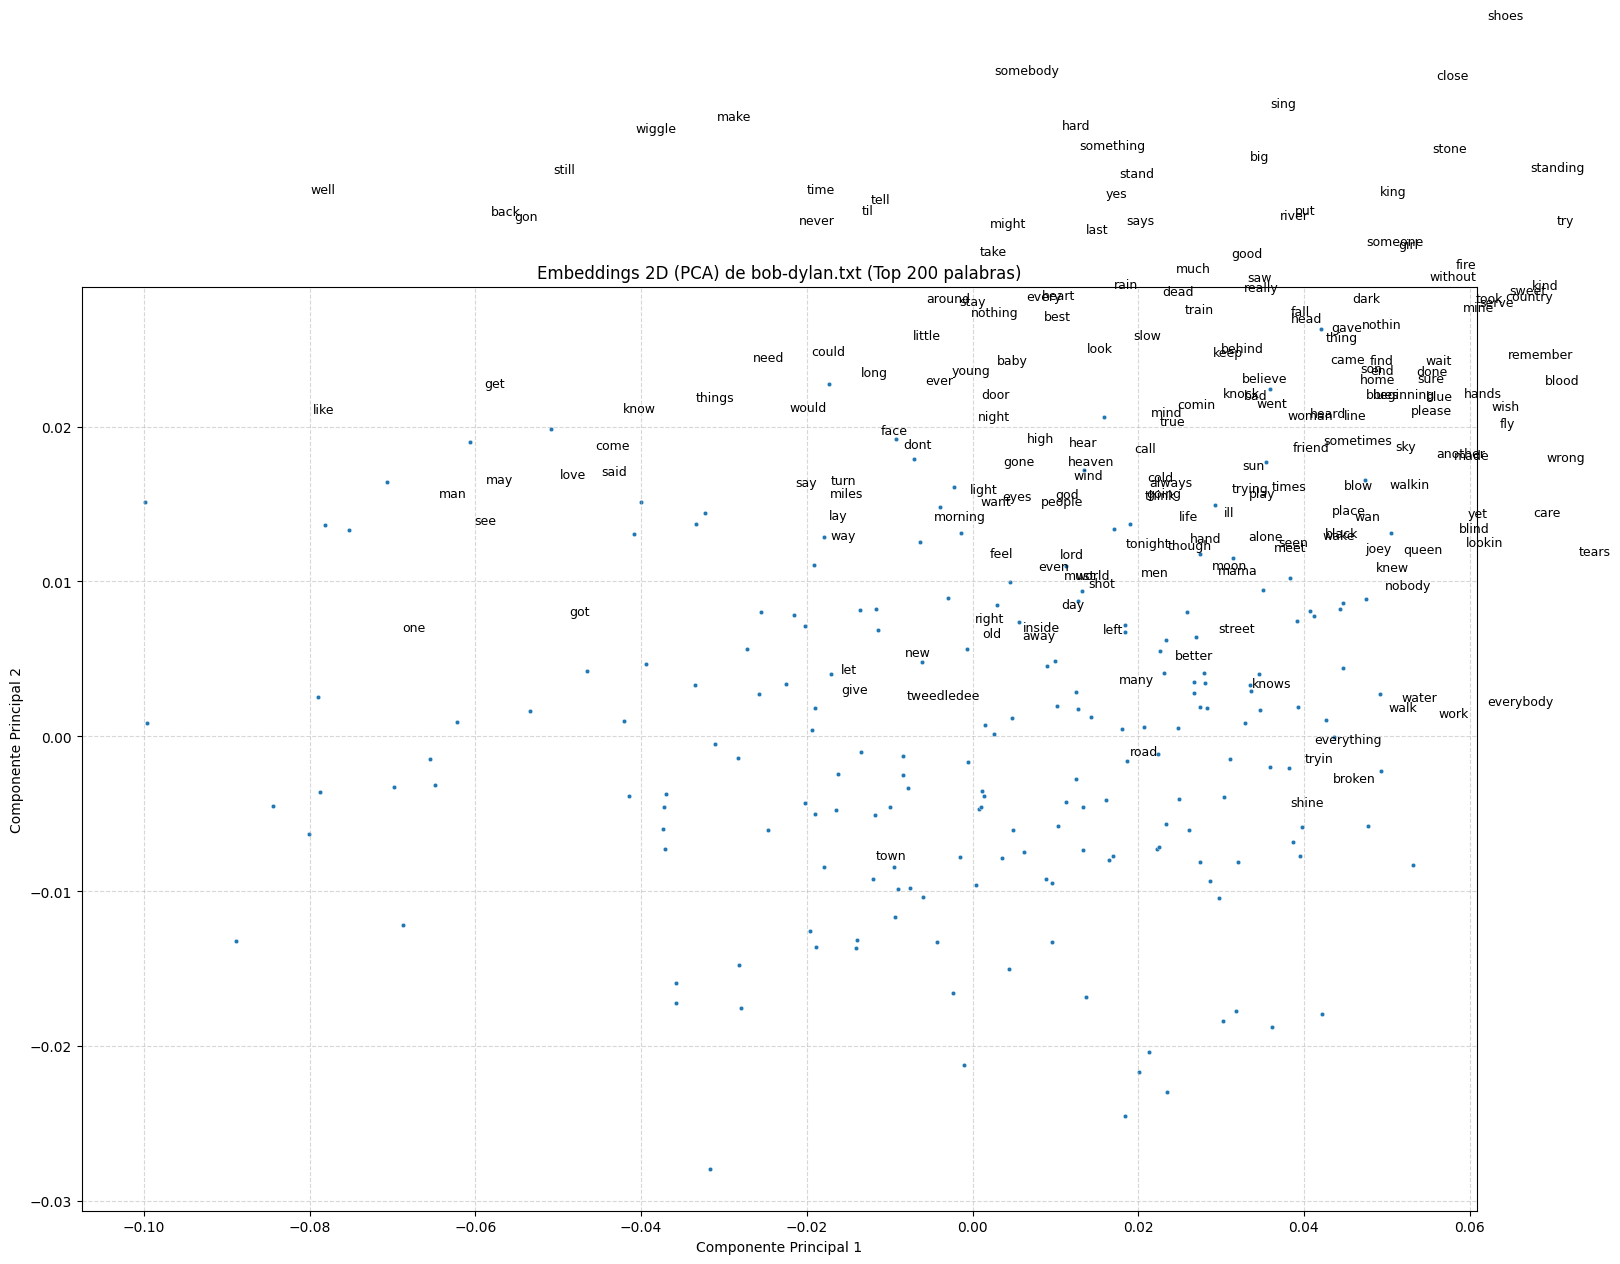

In [18]:
print("Generando gráfico de embeddings 2D...")

plt.figure(figsize=(18, 12))
sns.scatterplot(data=df_plot, x='pca1', y='pca2', s=10)

for i in range(df_plot.shape[0]):
    plt.text(
        x=df_plot.pca1[i] + 0.02,
        y=df_plot.pca2[i] + 0.02,
        s=df_plot.palabra[i],
        fontdict=dict(color='black', size=9)
    )

plt.title(f'Embeddings 2D (PCA) de {ARTISTA_ELEGIDO} (Top {MAX_WORDS} palabras)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Conclusiones

El notebook se ejecutó correctamente. Cargué las letras de Bob Dylan, las procesé y entrené el modelo Word2Vec sin errores. Sin embargo, el principal problema fue que el vocabulario que aprendió el modelo fue demasiado pequeño (solo 772 palabras). Esto ocurrió porque el filtro min_count=5 fue muy estricto y eliminó la mayoría de las palabras, dejando solo las más comunes.

A causa de este vocabulario tan limitado, el modelo no logró capturar el significado real de las letras. En lugar de aprender relaciones semánticas (como 'road' con 'highway'), el modelo solo aprendió la frecuencia con la que palabras muy comunes (como 'like' o 'said') aparecían juntas. Las pruebas de similitud confirmaron esto, dando resultados ilógicos. La conclusión es que, aunque el código funcionó, los hiperparámetros no fueron los adecuados. Para mejorar los resultados, debería volver a entrenar el modelo bajando el filtro a min_count=2 para obtener un vocabulario más rico y relaciones más coherentes.